In [1]:
#%pip install torchsummary
#%pip install seaborn
#%pip install tqdm

In [2]:
import os
import pathlib
import random
import time

import intel_extension_for_pytorch as ipex
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import tqdm
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
from torchsummary import summary 

sns.set_theme(style="whitegrid", palette="husl")

2022-06-17 14:04:44,262 - numexpr.utils - INFO - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-06-17 14:04:44,262 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [3]:
print(f"torch version: {torch.__version__}")
print(f"ipex version: {ipex.__version__}")

torch version: 1.11.0
ipex version: 1.11.200


In [4]:
device = "cpu" # torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device used: {device}")


def to_device(data, device):
    """move data to device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device=device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    def __init__(self, data_loader, device):
        self.data_loader = data_loader
        self.device = device

    def __iter__(self):
        for batch in self.data_loader:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.data_loader)


def seed_everything(seed: int = 4242):
    print(f"seed set to: {seed}")
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if device != "cpu":
        torch.cuda.manual_seed_all(seed)


def set_env_vars():
    num_physical_cores = psutil.cpu_count(logical=False)
    print(f"setting omp num threads: {num_physical_cores}")
    os.environ["OMP_NUM_THREADS"] = str(num_physical_cores)
    os.environ["KMP_AFFINITY"] = "granularity=fine,compact,1,0"
    os.environ["KMP_BLOCKTIME"] = "1"
    torch.set_num_interop_threads(2)
    torch.set_num_threads(num_physical_cores)


seed_everything(9342)
set_env_vars()

device used: cpu
seed set to: 9342
setting omp num threads: 10


In [5]:
# training and test dataset transforms
imagenet_stats = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
train_transform = transforms.Compose(
    [
        transforms.RandomApply(
            [
                transforms.GaussianBlur(kernel_size=(1, 3), sigma=(1, 3)),
                # transforms.RandomVerticalFlip()
            ],
            p=0.2,
        ),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(180),
        transforms.ToTensor(),
        transforms.Normalize(*imagenet_stats),
    ]
)

valid_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(*imagenet_stats),
    ]
)


In [6]:
# create dataset for Training, Testing and Validation
num_physical_cores = psutil.cpu_count(logical=False)
batch_size = 64
data_dir = pathlib.Path("./data/ThreeClassBalanced5000/")
TRAIN_DIR = data_dir / "train"
VALID_DIR = data_dir / "val"

train_data = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
valid_data = datasets.ImageFolder(VALID_DIR, transform=valid_transform)

train_data_size = int(len(train_data) * 0.8)
test_data_size = len(train_data) - train_data_size
train_data, test_data = random_split(train_data, [train_data_size, test_data_size])

print(
    f"Dataset size:\n training:: {len(train_data)}\n testing: {len(test_data)}\n validation:: {len(valid_data)}"
)

train_dataloader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=1
)  # math.ceil(num_physical_cores / 4)), pin_memory=True)
test_dataloader = DataLoader(
    valid_data, batch_size=batch_size * 2, num_workers=1
)  # math.ceil(num_physical_cores / 4)), pin_memory=True))   # use for testing at the end, not used for training or val
valid_dataloader = DataLoader(
    valid_data, batch_size=batch_size * 2, num_workers=1
)  # math.ceil(num_physical_cores / 4)), pin_memory=True)  # no backprob so can use double batch_size for validation


Dataset size:
 training:: 2913
 testing: 729
 validation:: 896


In [7]:
# view dataset
def denormalize(images, imagenet_stats):
    """de normalize dataset using imagenet std and mean"""
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    mean = torch.tensor(imagenet_stats[0]).reshape(1, 3, 1, 1)
    std = torch.tensor(imagenet_stats[1]).reshape(1, 3, 1, 1)
    return images * std + mean

In [8]:
def view_data(dataloader, imagenet_stats, samples=4):
    """pick first n samples and show them."""
    for imgs, labls in dataloader:
        _, ax = plt.subplots(figsize=(8, 4))
        imgs = denormalize(imgs[:samples], imagenet_stats)
        print("labels: ", labls[:samples].tolist())
        ax.imshow(make_grid(imgs, nrow=4).permute(1, 2, 0))
        break

labels:  [1, 1, 0, 1]


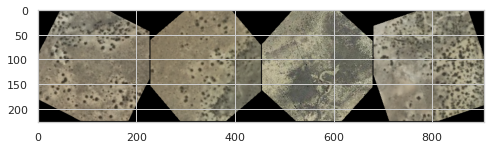

In [9]:
# training data
view_data(train_dataloader, imagenet_stats, samples=4)

labels:  [0, 0, 0, 0]


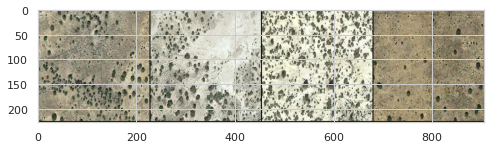

In [10]:
# validation data
view_data(valid_dataloader, imagenet_stats)

In [11]:
class DinosourBoneFinder(nn.Module):
    def __init__(self, backbone=18, simple=False):
        super(DinosourBoneFinder, self).__init__()
        backbones = {
            18: models.resnet18,
            34: models.resnet34,
            50: models.resnet50,
            101: models.resnet101,
        }
        self.network = backbones[backbone](pretrained=True)
        for m, p in zip(self.network.modules(), self.network.parameters()):
            if isinstance(m, nn.BatchNorm2d):
                p.requires_grad = False
        if simple:
            self.network.fc = nn.Linear(self.network.fc.in_features, 3)
        else:
            self.network.fc = nn.Sequential(
                nn.Linear(self.network.fc.in_features, 256),
                nn.ReLU(),
                nn.Dropout(0.6),
                nn.Linear(256, 3),
            )

    def forward(self, x_batch):
        return self.network(x_batch)

    def batch_training(self, batch):
        """training step for each batch."""
        images, labels = batch
        yhats = self(images)
        return F.cross_entropy(yhats, labels)

    def batch_validation(self, batch):
        """return validation loss/accuracy scores at the end of each batch."""
        images, labels = batch
        yhats = self(images)
        loss = F.cross_entropy(yhats, labels)
        acc = DinosourBoneFinder.accuracy(yhats, labels)
        return {"val_loss": loss.detach(), "val_acc": acc}

    def epoch_validation(self, outputs):
        """return validation loss/accuracy scores at the end of each epoch."""
        batch_losses = [x["val_loss"] for x in outputs]
        batch_acc = [x["val_acc"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    @staticmethod
    def accuracy(yhats, labels):
        yhats = torch.argmax(yhats, 1)
        return torch.sum(yhats == labels).double() / len(yhats)

    def epoch_metrics(self, epoch, result):
        """get scores at the end of each epoch"""
        print(
            "Epoch [{}], \ntrain_loss = {:.5f} \nvalidn_loss: {:5f} \nvalidn_acc: {:0.5f}".format(
                epoch, result["train_loss"], result["val_loss"], result["val_acc"]
            )
        )

In [12]:
def evaluate(model, valid_dataloader):
    model.eval()
    outputs = [model.batch_validation(batch) for batch in valid_dataloader]
    return model.epoch_validation(outputs)


def fit(epochs, model, train_dataloader, valid_dataloader, lr=2e-3, ipx=False):
    """fit the model for epochs using training and validation data.
        Return metrics history, learning rates used and time taken
        per epoch.
    """
    torch.cuda.empty_cache()  # prevent oom errors
    hist = []
    lrs = []
    time_per_epoch = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if ipx:
        model.train()
        model = model.to(memory_format=torch.channels_last)
        model, optimizer = ipex.optimize(
            model, optimizer=optimizer, dtype=torch.float32
        )
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr, total_steps=epochs
    )
    for epoch in range(epochs):
        st_time = time.perf_counter()
        epoch = epoch + 1
        model.train()
        train_losses = []
        for batch in tqdm.tqdm(train_dataloader):
            loss = model.batch_training(batch)
            train_losses.append(loss.data)
            loss.backward()
            optimizer.step()
            lrs.append(optimizer.param_groups[0]["lr"])
            optimizer.zero_grad(set_to_none=True)
        scheduler.step()
        with torch.no_grad():
            result = evaluate(model, valid_dataloader)
        result["train_loss"] = torch.stack(train_losses).mean().item()
        model.epoch_metrics(epoch, result)
        hist.append(result)
        e_time = time.perf_counter()
        time_per_epoch.append((e_time - st_time))
    return hist, lrs, time_per_epoch


def save(model, m_version=""):
    """save model checkpoint"""
    torch.save(
        model.state_dict(),
        pathlib.Path(f"./saved_checkpoints/{m_version}_model.pt").mkdir(parents=True, exist_ok=True),
    )


def load(path):
    """load model from checkpoint"""
    model = DinosourBoneFinder()
    model.load_state_dict(torch.load(path))
    return model

In [13]:
def fine_tune(model, train_dataloader, valid_dataloader, test_dataloader, ipx=False):
    """fine tune model for 10 epochs and return model metrics"""
    epochs = 10
    torch.set_num_threads(10)
    train_dataloader = DeviceDataLoader(train_dataloader, device)
    valid_dataloader = DeviceDataLoader(valid_dataloader, device)
    test_dataloader = DeviceDataLoader(test_dataloader, device)
    model = to_device(model, device)
    hist, _, time_per_epoch = fit(
        epochs, model, train_dataloader, valid_dataloader, ipx=ipx
    )
    loss, acc = evaluate(model, test_dataloader).values()
    print(
        "testdata loss (not seen by model): {:.4f}, accuracy: {:.4f}".format(loss, acc)
    )
    return hist, time_per_epoch

In [14]:
torch.get_num_threads()

10

In [20]:
def plot_metrics(history, backbone=18):
    """plot loss and acc curves"""
    train_loss = [x["train_loss"] for x in history]
    val_loss = [x["val_loss"] for x in history]
    val_acc = [x["val_acc"] for x in history]
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 2.5))
    ax[0].plot(train_loss, "-o")
    ax[0].plot(val_loss, "-o")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")
    ax[0].set_title(f"Train vs Validation loss with resnet-{backbone}")
    ax[1].plot(val_acc, "-o")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("acc")
    ax[1].set_title(f"Validation acc with resnet-{backbone}")
    ax[0].legend(["train", "validation"])
    for x in ax:
        x.yaxis.grid(True)
        x.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
       
    plt.show()


def _create_dataframe(ipx_off, ipx_on):
    stats = pd.DataFrame()
    stats["ipx_on"] = ipx_on
    stats["ipx_off"] = ipx_off
    return stats


def time_comparision(ipx_off, ipx_on):
    """compare time taken for each epoch with ipx on/off"""
    try:
        import seaborn as sns
    except ImportError:
        print("seaborn not install to check running time")
    stats = _create_dataframe(ipx_off, ipx_on)
    sns.set(rc={"figure.figsize": (8, 8)})
    p = sns.boxplot(data=stats, linewidth=2)
    p.set_xlabel("mode")
    p.set_ylabel("time in seconds")
    p.set_title("Running time comparision for resnet fintetuning with ipx on/off")
    return p

In [16]:
# train models with ipx off an on, using ResNet18 as the backbone
model_small = DinosourBoneFinder(backbone=18)
hist_small_ipx_off, time_per_epoch_small_ipx_off = fine_tune(model_small, train_dataloader, valid_dataloader, test_dataloader, ipx=False)
model_small = DinosourBoneFinder(backbone=18)
hist_small_ipx_on, time_per_epoch_small_ipx_on = fine_tune(model_small, train_dataloader, valid_dataloader, test_dataloader, ipx=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [01:04<00:00,  1.40s/it]


Epoch [1], 
train_loss = 0.47710 
validn_loss: 0.262314 
validn_acc: 0.90625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [01:07<00:00,  1.47s/it]


Epoch [2], 
train_loss = 0.26003 
validn_loss: 0.462313 
validn_acc: 0.79576


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [01:08<00:00,  1.48s/it]


Epoch [3], 
train_loss = 0.27393 
validn_loss: 0.574472 
validn_acc: 0.75112


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [01:06<00:00,  1.46s/it]


Epoch [4], 
train_loss = 0.20782 
validn_loss: 0.295020 
validn_acc: 0.91183


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [01:06<00:00,  1.45s/it]


Epoch [5], 
train_loss = 0.17993 
validn_loss: 0.434732 
validn_acc: 0.89286


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [01:06<00:00,  1.44s/it]


Epoch [6], 
train_loss = 0.16729 
validn_loss: 0.230741 
validn_acc: 0.91629


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [01:06<00:00,  1.45s/it]


Epoch [7], 
train_loss = 0.13079 
validn_loss: 0.190256 
validn_acc: 0.92857


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [01:07<00:00,  1.47s/it]


Epoch [8], 
train_loss = 0.10071 
validn_loss: 0.123745 
validn_acc: 0.95312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [01:05<00:00,  1.42s/it]


Epoch [9], 
train_loss = 0.08938 
validn_loss: 0.107564 
validn_acc: 0.95536


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [01:06<00:00,  1.45s/it]


Epoch [10], 
train_loss = 0.08918 
validn_loss: 0.102824 
validn_acc: 0.95759


/home/unrahul/anaconda3/envs/pyt-gpu/lib/python3.9/site-packages/intel_extension_for_pytorch/optim/_optimizer_utils.py:207: UserWarning: Does not suport fused step for <class 'torch.optim.adam.Adam'>, will use non-fused step
  warnings.warn("Does not suport fused step for " + str(type(optimizer)) + ", will use non-fused step")


testdata loss (not seen by model): 0.1028, accuracy: 0.9576


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:58<00:00,  1.28s/it]


Epoch [1], 
train_loss = 0.47074 
validn_loss: 0.230325 
validn_acc: 0.89844


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:58<00:00,  1.27s/it]


Epoch [2], 
train_loss = 0.26448 
validn_loss: 0.270540 
validn_acc: 0.91853


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:57<00:00,  1.26s/it]


Epoch [3], 
train_loss = 0.24755 
validn_loss: 1.305188 
validn_acc: 0.50893


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:57<00:00,  1.25s/it]


Epoch [4], 
train_loss = 0.27882 
validn_loss: 0.750266 
validn_acc: 0.74777


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:59<00:00,  1.30s/it]


Epoch [5], 
train_loss = 0.19869 
validn_loss: 0.387764 
validn_acc: 0.82254


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:58<00:00,  1.28s/it]


Epoch [6], 
train_loss = 0.16813 
validn_loss: 0.133992 
validn_acc: 0.94643


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:58<00:00,  1.27s/it]


Epoch [7], 
train_loss = 0.11850 
validn_loss: 0.129242 
validn_acc: 0.94531


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:59<00:00,  1.29s/it]


Epoch [8], 
train_loss = 0.11233 
validn_loss: 0.114748 
validn_acc: 0.96317


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:59<00:00,  1.29s/it]


Epoch [9], 
train_loss = 0.09966 
validn_loss: 0.093820 
validn_acc: 0.96875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:59<00:00,  1.29s/it]


Epoch [10], 
train_loss = 0.08849 
validn_loss: 0.092178 
validn_acc: 0.96763
testdata loss (not seen by model): 1.1120, accuracy: 0.3583


In [18]:
# let's summarize the model
#summary(to_device(model_small, device), (3, 224, 224))

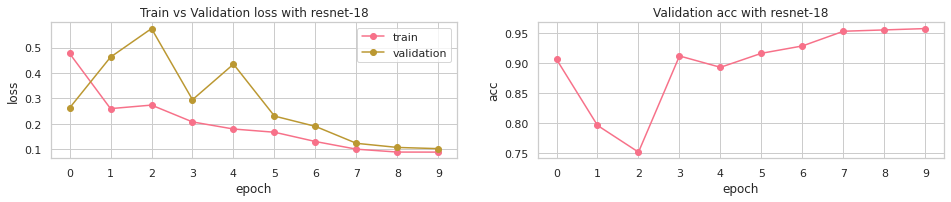

In [21]:
plot_metrics(hist_small_ipx_off)

<AxesSubplot:title={'center':'Running time comparision for resnet fintetuning with ipx on/off'}, xlabel='mode', ylabel='time in seconds'>

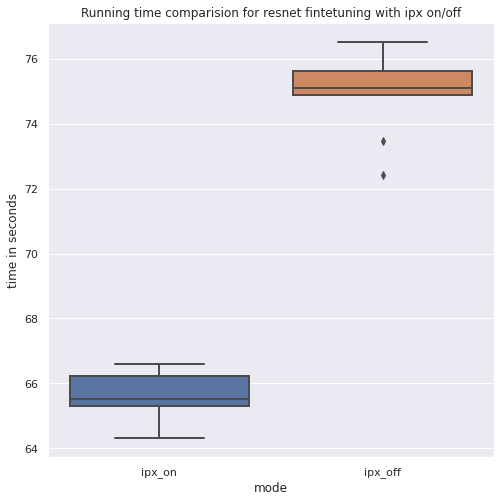

In [22]:
# compare ipx off vs on time per each epoch
time_comparision(time_per_epoch_small_ipx_off, time_per_epoch_small_ipx_on)

In [26]:
# percentage difference between ipex_off and ipex_on
print(f"percentage diff in time to run (ipx off vs on): {-(np.mean(time_per_epoch_small_ipx_off) - np.mean(time_per_epoch_small_ipx_on) / np.mean(time_per_epoch_small_ipx_off) * 100):.4} %")

percentage diff in time to run (ipx off vs on): 12.52 %
